In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
!pip install kagglehub

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubash1","key":"829e8fb5d7561835249fa1d6440a7b9f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors


In [ ]:
import zipfile
import os

dataset_zip = "garbage-classification.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("garbage_classification")

data_dir = "garbage_classification/Garbage classification/Garbage classification"
print(os.listdir('garbage_classification'))
print(os.listdir(data_dir))


['Garbage classification', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'garbage classification', 'one-indexed-files-notrash_test.txt', 'zero-indexed-files.txt', 'one-indexed-files.txt']
['metal', 'paper', 'plastic', 'cardboard', 'trash', 'glass']


# **Transformations:**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


dataset = ImageFolder(data_dir)


In [ ]:
from torchvision.transforms import ToTensor
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    img_tensor = ToTensor()(img)
    plt.imshow(img_tensor.permute(1, 2, 0))

Label: cardboard (Class No: 0)


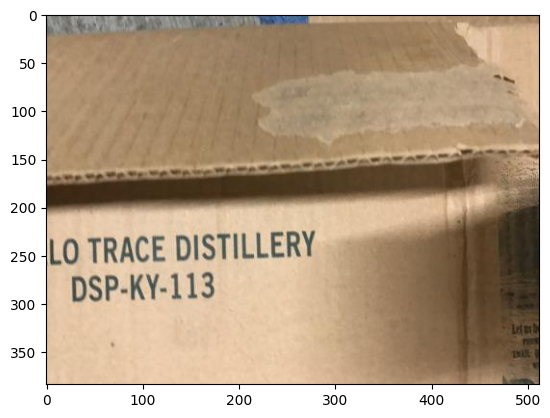

In [ ]:
img, label = dataset[12]
show_sample(img, label)

## **Loading and Splitting Data:**

In [ ]:
class_counts = Counter(dataset.targets)
max_class_count = max(class_counts.values())

print("Class distribution before balancing:", dict(sorted(class_counts.items())))

def oversample_dataset(dataset, max_count):
    new_samples = []

    for label in class_counts:
        images = [sample for sample in dataset.samples if sample[1] == label]

        image_paths = [image[0] for image in images]

        additional_samples = max_count - len(images)

        new_samples.extend(images)

        if additional_samples > 0:
            sampled_images = np.random.choice(image_paths, additional_samples, replace=True)
            new_samples.extend([(img, label) for img in sampled_images])

    dataset.samples = new_samples
    dataset.targets = [label for _, label in dataset.samples]

# Perform Oversampling on Training Set
oversample_dataset(dataset, max_class_count)

# Compute Class Distribution After Balancing
class_counts_after = Counter(dataset.targets)
print("Class distribution after oversampling:", dict(sorted(class_counts_after.items())))

Class distribution before balancing: {0: 403, 1: 501, 2: 410, 3: 594, 4: 482, 5: 137}
Class distribution after oversampling: {0: 594, 1: 594, 2: 594, 3: 594, 4: 594, 5: 594}


In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_ds.dataset.transform = train_transforms
val_ds.dataset.transform = val_transforms
test_ds.dataset.transform = val_transforms

len(train_ds), len(val_ds), len(test_ds)

(2494, 534, 536)

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

print(f"Train set: {len(train_ds)}, Validation set: {len(val_ds)}, Test set: {len(test_ds)}")


Train set: 2494, Validation set: 534, Test set: 536


In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

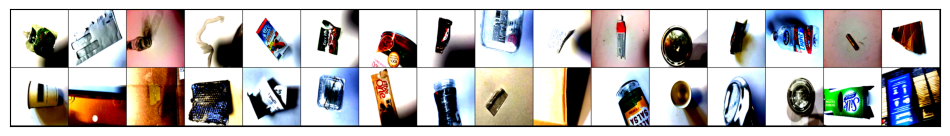

In [ ]:
show_batch(train_dl)

# **Model Base:**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

## **ViT**

In [ ]:
from torchvision.models import vit_b_16
class Classification_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = vit_b_16(pretrained=True)
        num_ftrs = self.network.heads.head.in_features
        self.dropout = nn.Dropout(0.2)
        self.network.heads.head = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        x = self.network(xb)
        x = self.dropout(x)
        return x


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = to_device(Classification_Model(), device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 218MB/s]


# **Porting to GPU:**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

Classification_Model(
  (network): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          

# **Training the Model:**

In [ ]:
@torch.no_grad()
def print_metrics(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in val_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # Print Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        correct = 0
        total = 0

        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)  # Get the class index with max probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        accuracy = correct / total
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = accuracy
        model.epoch_end(epoch, result)
        history.append(result)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {result['train_loss']:.4f}, Train Accuracy: {result['train_accuracy']*100:.4f}")

    return history


In [ ]:
model = to_device(Classification_Model(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.8798718452453613, 'val_acc': 0.15223930776119232}

In [ ]:
num_epochs = 50
opt_func = torch.optim.Adam
lr=1e-4
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.6715, val_loss: 0.2969, val_acc: 0.9073
Epoch [1/50], Train Loss: 0.6715, Train Accuracy: 73.9775
Epoch 2: train_loss: 0.2500, val_loss: 0.2379, val_acc: 0.9357
Epoch [2/50], Train Loss: 0.2500, Train Accuracy: 89.0938
Epoch 3: train_loss: 0.2256, val_loss: 0.2813, val_acc: 0.9164
Epoch [3/50], Train Loss: 0.2256, Train Accuracy: 90.6175
Epoch 4: train_loss: 0.2021, val_loss: 0.2613, val_acc: 0.9221
Epoch [4/50], Train Loss: 0.2021, Train Accuracy: 89.8957
Epoch 5: train_loss: 0.1896, val_loss: 0.2858, val_acc: 0.9119
Epoch [5/50], Train Loss: 0.1896, Train Accuracy: 91.1788
Epoch 6: train_loss: 0.2318, val_loss: 0.2857, val_acc: 0.9109
Epoch [6/50], Train Loss: 0.2318, Train Accuracy: 89.3344
Epoch 7: train_loss: 0.1834, val_loss: 0.4114, val_acc: 0.9046
Epoch [7/50], Train Loss: 0.1834, Train Accuracy: 89.8557
Epoch 8: train_loss: 0.2281, val_loss: 0.4326, val_acc: 0.8925
Epoch [8/50], Train Loss: 0.2281, Train Accuracy: 88.2919
Epoch 9: train_loss: 0.1667, val

Evaluating on test set...


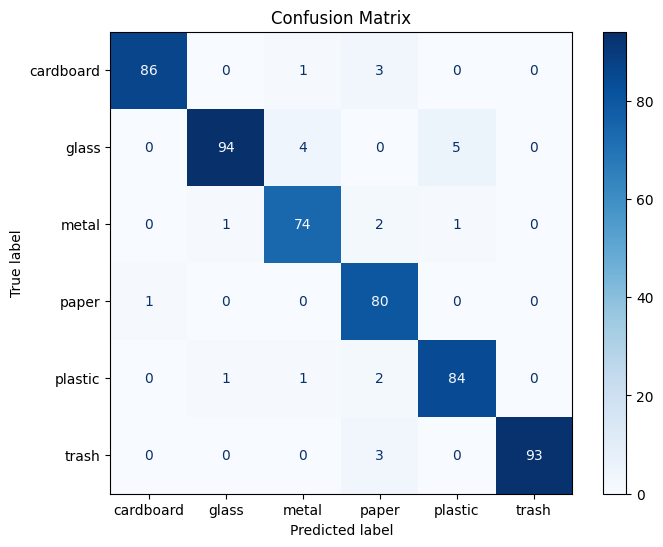


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.96      0.97        90
       glass       0.98      0.91      0.94       103
       metal       0.93      0.95      0.94        78
       paper       0.89      0.99      0.94        81
     plastic       0.93      0.95      0.94        88
       trash       1.00      0.97      0.98        96

    accuracy                           0.95       536
   macro avg       0.95      0.95      0.95       536
weighted avg       0.96      0.95      0.95       536



In [ ]:
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

@torch.no_grad()
def evaluate_test_set(model, test_loader, class_names):
    print("Evaluating on test set...")
    print_metrics(model, test_loader, class_names)

evaluate_test_set(model, test_dl, dataset.classes)


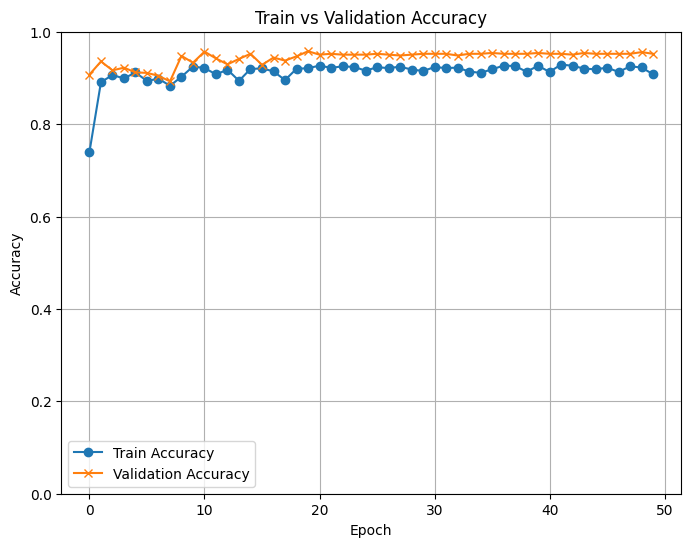

In [ ]:
def plot_accuracies(history):
    train_accuracies = [x['train_accuracy'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]

    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracies, '-o', label='Train Accuracy')
    plt.plot(val_accuracies, '-x', label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies(history)


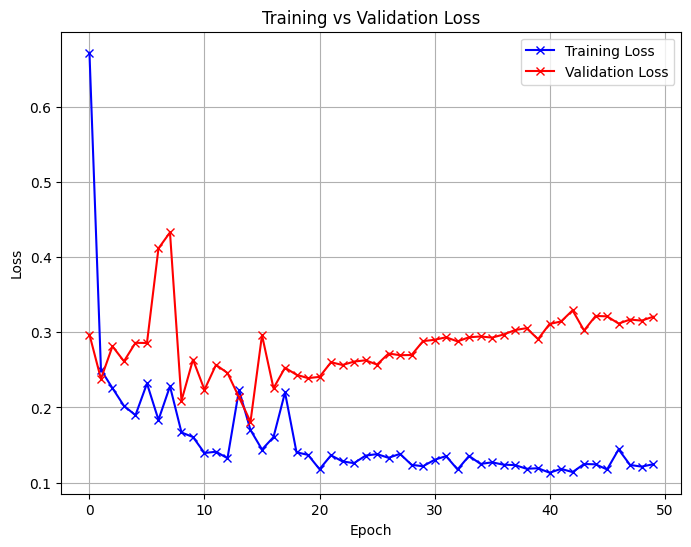

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]

    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(history)

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: plastic , Predicted: plastic


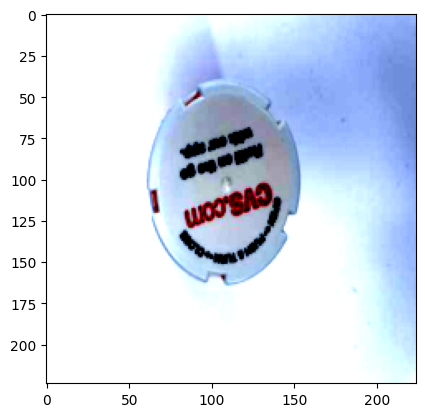

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: paper


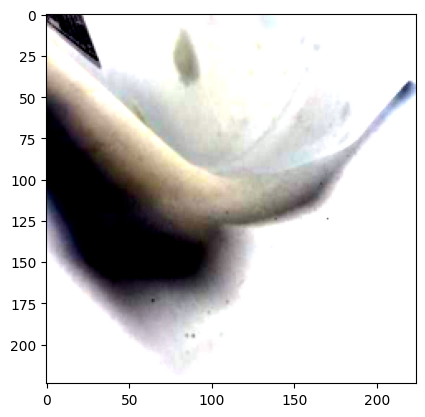

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: metal , Predicted: metal


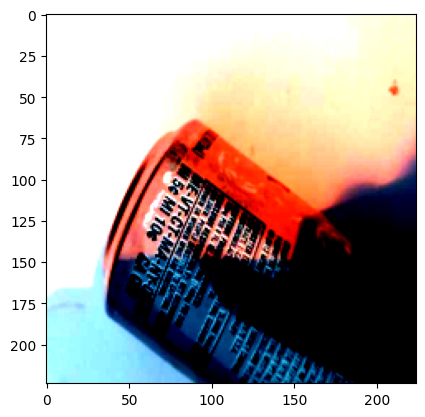

In [ ]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))